The purpose of this notebook is to use transfer learning in order to predict the Historical period of artworks from MET given images. In order to do that, we use GPU offered by Google Colab


# Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from google.colab import drive

The dataset is stored in google drive

In [3]:
#get access to google colab
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
"""
The dataset is stored in a zip file 
"""
zip_file = '/content/gdrive/MyDrive/dataset_final.zip' #path of the dataset

Run the following cell if and only if you have not yet unzip your dataset

In [5]:
import zipfile
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/gdrive/MyDrive')

In the following cell, we create the train, validation and test dataset

In [17]:
batch_size = 64
IMG_SIZE = (224, 224) #specific for VGG16
IMG_SHAPE = IMG_SIZE + (3,)

data_dir_train = os.path.join('/content/gdrive/MyDrive/dataset_final', 'TRAIN')

train_data = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  image_size= IMG_SIZE,
  seed=1,
  batch_size= batch_size)


val_data = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size= IMG_SIZE,
  batch_size= batch_size)


data_dir_test_balanced = os.path.join('/content/gdrive/MyDrive/dataset_final', 'TEST_BALANCED')
test_data_balanced = tf.keras.utils.image_dataset_from_directory(
  data_dir_test_balanced,
  image_size= IMG_SIZE,
  seed=1,
  batch_size= batch_size)


data_dir_test_unbalanced = os.path.join('/content/gdrive/MyDrive/dataset_final', 'TEST_UNBALANCED')
test_data_unbalanced = tf.keras.utils.image_dataset_from_directory(
  data_dir_test_unbalanced,
  image_size= IMG_SIZE,
  seed=1,
  batch_size= batch_size)

Found 3182 files belonging to 4 classes.
Using 2546 files for training.
Found 3182 files belonging to 4 classes.
Using 636 files for validation.
Found 796 files belonging to 4 classes.
Found 199 files belonging to 4 classes.


We import VGG16 in order to do transfer learning for our specific problem

In [18]:
base_model = VGG16(input_shape=IMG_SHAPE , weights='imagenet', include_top=False)

# don't train existing weights
for layer in base_model.layers:
    layer.trainable = False
  

In [26]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
rescale = tf.keras.layers.Rescaling(scale=1./255)
flatten = tf.keras.layers.Flatten()

We build our model. We change the last dense layer by putting a 4-dense layer with a softmax as activation function in order to achieve our classification problem

In [ ]:

x = Flatten()(base_model.output)
prediction = Dense(4, activation='softmax')(x)

# create a model object
model = Model(inputs=base_model.input, outputs=prediction)

# view the structure of the model
model.summary()

In [ ]:
from tensorflow.keras import optimizers
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=optimizers.Adam(learning_rate=0.01),
  metrics=['accuracy']
)


model.fit( 
    train_data,
    validation_data=val_data,
    epochs=20,
)

In [ ]:
"""
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = rescale(inputs)
x = base_model(x, training=False)
x = flatten(x)
prediction = Dense(4, activation='softmax')(x)

model2 = tf.keras.Model(inputs=inputs, outputs=prediction)

model2.summary()



from tensorflow.keras import optimizers
model2.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=optimizers.Adam(learning_rate=0.01),
  metrics=['accuracy']
)


model2.fit( 
    train_data,
    validation_data=val_data,
    epochs=20,
)
"""

The loss used is categorial cross entropy and the metric is accuracy

In [ ]:
#save the model in order to re-use the weights
name_model = 'vgg16_customized.h5'
model.save(name_model)

In [ ]:
#loaded_model = tf.keras.models.load_model("vgg16_customized.h5")

In [33]:
score = model.evaluate(test_data_balanced, verbose=False)
print('Test accuracy:', score[1])

Test accuracy: 0.6168341636657715


In [34]:
score = model.evaluate(test_data_unbalanced, verbose=False)
print('Test accuracy:', score[1])

Test accuracy: 0.6030150651931763


In [37]:
"""
score = model2.evaluate(test_data_balanced, verbose=False)
print('Test accuracy:', score[1])
score = model2.evaluate(test_data_unbalanced, verbose=False)
print('Test accuracy:', score[1])
"""

Test accuracy: 0.6407034993171692
Test accuracy: 0.6281406879425049


In [ ]:
predictions = np.array([])
true_labels =  np.array([])
for x, y in test:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=1)])
  true_labels = np.concatenate([true_labels, y.numpy()])

In [ ]:
tf.math.confusion_matrix(labels=true_labels, predictions=predictions).numpy()

array([[26,  0,  8,  0],
       [ 0, 24,  1,  7],
       [ 2,  4, 19,  1],
       [ 4, 19, 32, 52]], dtype=int32)

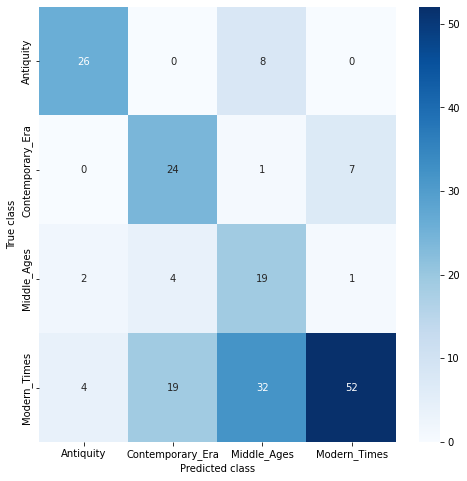

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(true_labels, predictions)
map_period = { "Antiquity":0., "Contemporary_Era":1., "Middle_Ages":2.,"Modern_Times": 3.}
plt.figure(figsize=(8,8))
sns.heatmap(conf_mat, cmap="Blues",
annot=True, xticklabels=map_period.keys(),
yticklabels=map_period.keys(),
)

plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

In [ ]:
class_names = train.class_names
print(class_names)

['Antiquity', 'Contemporary_Era', 'Middle_Ages', 'Modern_Times']


In [ ]:
import cv2

def predict_single_image(image_path,model, class_names, image_size):
  """
  @inputs : image_path : the path to the image we want to predict the class
            model : architecture used for the prediction
            class_names : the name of the 4 classes
  
  @output : show the image and give the class predicted by the model

  """

  #import the image and resize it for the model
  image_to_predict = cv2.imread(image_path,cv2.IMREAD_COLOR)
  img_to_predict = np.expand_dims(cv2.resize(image_to_predict, image_size), axis=0) 

  #prediction of the class by the model
  res = np.argmax(model.predict(img_to_predict), axis=1)
  prediction = class_names[res[0]] #to have the name of the class instead of a number

  plt.imshow(cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2RGB))
  plt.title(f'prediction : {prediction}')
  plt.show()


In [ ]:
image_path = os.path.join('/content/gdrive/MyDrive/', 'louvre4.JPG')

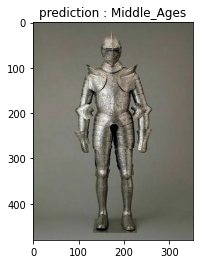

In [ ]:
predict_single_image(image_path,model, class_names, (224,224))

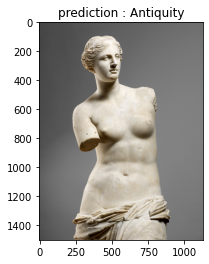

In [ ]:
image_path = os.path.join('/content/gdrive/MyDrive/', 'louvre2.jpg')
predict_single_image(image_path,model, class_names)

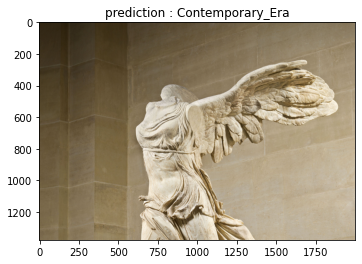

In [ ]:
image_path = os.path.join('/content/gdrive/MyDrive/', 'louvre3.jpg')
predict_single_image(image_path,model, class_names)